# Finetuning Segment Anything with `µsam`

This notebook shows how to use Segment Anything for Microscopy to fine-tune a Segment Anything Model (SAM) on your custom data.

We use DIC microscopy images from the Cell Tracking Challenge, DIC-C2DH-HeLa, HeLa cells on a flat glass (from [Maška et al.](https://www.nature.com/articles/s41592-023-01879-y)) in this notebook. The functionalities shown here should work for your (microscopy) images too.

## Running this notebook

If you have an environment with `µsam` on your computer you can run this notebook in there. You can follow the [installation instructions](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation) to install it on your computer.

You can also run this notebook in the cloud on [Kaggle Notebooks](https://www.kaggle.com/code/). This service offers free usage of a GPU to speed up running the code. The next cells will take care of the installation for you if you are using it.

In [93]:
# Check if we are running this notebook on kaggle, google colab or local compute resources.

import os
current_spot = os.getcwd()

if current_spot.startswith("/kaggle/working"):
    print("Kaggle says hi!")
    root_dir = "/kaggle/working"

elif current_spot.startswith("/content"):
    print("Google Colab says hi!")
    print(" NOTE: The scripts have not been tested on Google Colab, you might need to adapt the installations a bit.")
    root_dir = "/content"

    # You might need to install condacolab on Google Colab to be able to install packages using conda / mamba
    # !pip install -q condacolab
    # import condacolab
    # condacolab.install()

else:
    msg = "You are using a behind-the-scenes resource. Follow our installation instructions here:"
    msg += " https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation"
    print(msg)
    root_dir = ""  # overwrite to set the root directory, where the data, checkpoints, and all relevant stuff will be stored

You are using a behind-the-scenes resource. Follow our installation instructions here: https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation


### Installation

The next cells will install the `micro_sam` library on Kaggle Notebooks. **Please skip these cells and go to `Importing the libraries` if you are running the notebook on your own computer.**

In [2]:
!git clone --quiet https://github.com/computational-cell-analytics/micro-sam.git
tmp_dir = os.path.join(root_dir, "micro-sam")
!pip install --quiet $tmp_dir

In [3]:
!git clone --quiet https://github.com/constantinpape/torch-em.git
tmp_dir = os.path.join(root_dir, "torch-em")
!pip install --quiet $tmp_dir

In [4]:
!git clone --quiet https://github.com/constantinpape/elf.git
tmp_dir = os.path.join(root_dir, "elf")
!pip install --quiet $tmp_dir

Known Issues on **Kaggle Notebooks**:

1. `warning  libmamba Cache file "/opt/conda/pkgs/cache/2ce54b42.json" was modified by another program` (multiples lines of such warnings)
    - We have received this warning while testing this notebook on Kaggle. It does not lead to any issues while making use of the installed packages. You can proceed and ignore the warnings.

In [5]:
!mamba install -q -y -c conda-forge nifty affogato zarr z5py
!pip uninstall -y --quiet qtpy  # qtpy is not supported in Kaggle / Google Colab, let's remove it to avoid errors.

warning  libmamba Cache file "/opt/conda/pkgs/cache/497deca9.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/09cdf8bf.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/c6f2354e.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/86b0f08d.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/c9ddbd6b.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/b121c3e7.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/47929eba.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/3e39a7aa.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/2ce54b42.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/4ea078d6.json" was modified by another program
Preparing 

### Importing the libraries

In [94]:
from glob import glob
from IPython.display import FileLink

import tifffile
import numpy as np
import imageio.v3 as imageio
from matplotlib import pyplot as plt
from skimage.measure import label as connected_components

import torch

import torch_em
from torch_em.model import UNETR
from torch_em.util.debug import check_loader
from torch_em.loss import DiceBasedDistanceLoss
from torch_em.util.util import get_random_colors
from torch_em.transform.label import PerObjectDistanceTransform

from micro_sam import util
import micro_sam.training as sam_training
from micro_sam.sample_data import fetch_tracking_example_data, fetch_tracking_segmentation_data
from micro_sam.instance_segmentation import (
    InstanceSegmentationWithDecoder,
    get_predictor_and_decoder,
    mask_data_to_segmentation
)

### Let's download the dataset

In [95]:
DATA_FOLDER = '/home/matlabuser/Documents/SAM/'#os.path.join(root_dir, "data")
os.makedirs(DATA_FOLDER, exist_ok=True)

# This will download the image and segmentation data for training.
image_dir = '/home/matlabuser/Documents/SAM/images'
segmentation_dir = '/home/matlabuser/Documents/SAM/labels'

### Let's create the dataloaders

Our task is to segment HeLa cells on a flat glass in DIC microscopic images. The dataset comes from https://celltrackingchallenge.net/2d-datasets/, and the dataloader has been implemented in [torch-em](https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/ctc.py).

#### First, let's visualize how our samples look.

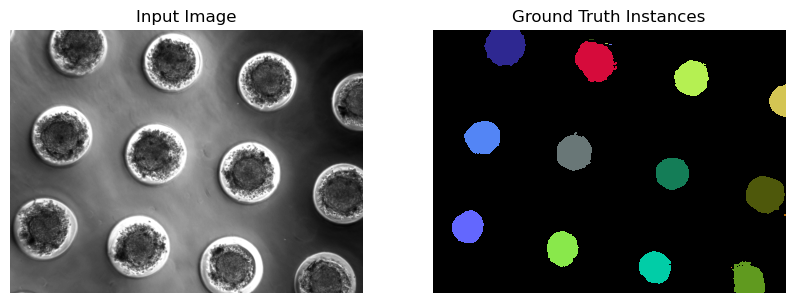

In [96]:
image_paths = sorted(glob(os.path.join(image_dir, "*")))
segmentation_paths = sorted(glob(os.path.join(segmentation_dir, "*")))

for image_path, segmentation_path in zip(image_paths, segmentation_paths):
    image = imageio.imread(image_path)
    segmentation = imageio.imread(segmentation_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Input Image")
    ax[0].axis("off")
    
    segmentation = connected_components(segmentation)
    ax[1].imshow(segmentation, cmap=get_random_colors(segmentation), interpolation="nearest")
    ax[1].set_title("Ground Truth Instances")
    ax[1].axis("off")
    
    plt.show()
    plt.close()
    
    break  # comment this out in case you want to visualize all the images

#### Next, let's create the dataloaders

In [103]:
# torch_em.default_segmentation_loader is a convenience function to build a torch dataloader
# from image data and labels for training segmentation models.
# It supports image data in various formats. Here, we load image data and labels from the two
# folders with tif images that were downloaded by the example data functionality, by specifying
# `raw_key` and `label_key` as `*.tif`. This means all images in the respective folders that end with
# .tif will be loadded.
# The function supports many other file formats. For example, if you have tif stacks with multiple slices
# instead of multiple tif images in a foldder, then you can pass raw_key=label_key=None.
# For more information, here is the documentation: https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/README.md

# Load images from multiple files in folder via pattern (here: all tif files)
raw_key, label_key = "*.tif", "*.tif"

# Alternative: if you have tif stacks you can just set raw_key and label_key to None
# raw_key, label_key= None, None

# The 'roi' argument can be used to subselect parts of the data.
# Here, we use it to select the first 70 images (frames) for the train split and the other frames for the val split.
train_roi = np.s_[:15, :, :]
val_roi = np.s_[15:, :, :]

#### Label Transform

The idea here is to convert the ground-truth to the desired instance for finetuning Segment Anything, and in addition if desired, to learn the foreground and distances to the object centers and object boundaries.

In [104]:
class LabelTransform:
    def __init__(self, train_instance_segmentation):
        self.train_instance_segmentation = train_instance_segmentation
        
    def __call__(self, labels):
        if self.train_instance_segmentation:
            # Computes the distance transform for objects to jointly perform the additional decoder-based automatic instance segmentation (AIS) and finetune Segment Anything.
            label_transform = PerObjectDistanceTransform(
                distances=True,
                boundary_distances=True,
                directed_distances=False,
                foreground=True,
                instances=True,
                min_size=25
            )
        else:
            # Ensures the individual object instances.to finetune the clasiscal Segment Anything.
            label_transform = torch_em.transform.label.connected_components

        labels = label_transform(labels)
        return labels

In [105]:
# The script below returns the train or val data loader for finetuning SAM.

# The data loader must be a torch data loader that returns `x, y` tensors,
# where `x` is the image data and `y` are the labels.
# The labels have to be in a label mask instance segmentation format.
# i.e. a tensor of the same spatial shape as `x`, with each object mask having its own ID.
# Important: the ID 0 is reseved for background, and the IDs must be consecutive

# Here, we use `torch_em.default_segmentation_loader` for creating a suitable data loader from
# the example hela data. You can either adapt this for your own data or write a suitable torch dataloader yourself.
# Here's a quickstart notebook to create your own dataloaders: https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb

batch_size = 1  # the training batch size
patch_shape = (1, 512, 512)  # the size of patches for training

# Train an additional convolutional decoder for end-to-end automatic instance segmentation
train_instance_segmentation = True

label_transform = LabelTransform(train_instance_segmentation)

train_loader = torch_em.default_segmentation_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    patch_shape=patch_shape,
    batch_size=batch_size,
    ndim=2,
    is_seg_dataset=True,
    rois=train_roi,
    label_transform=label_transform,
    shuffle=True,
    raw_transform=sam_training.identity,
)
val_loader = torch_em.default_segmentation_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    patch_shape=patch_shape,
    batch_size=batch_size,
    ndim=2,
    is_seg_dataset=True,
    rois=val_roi,
    label_transform=label_transform,
    shuffle=True,
    raw_transform=sam_training.identity,
)

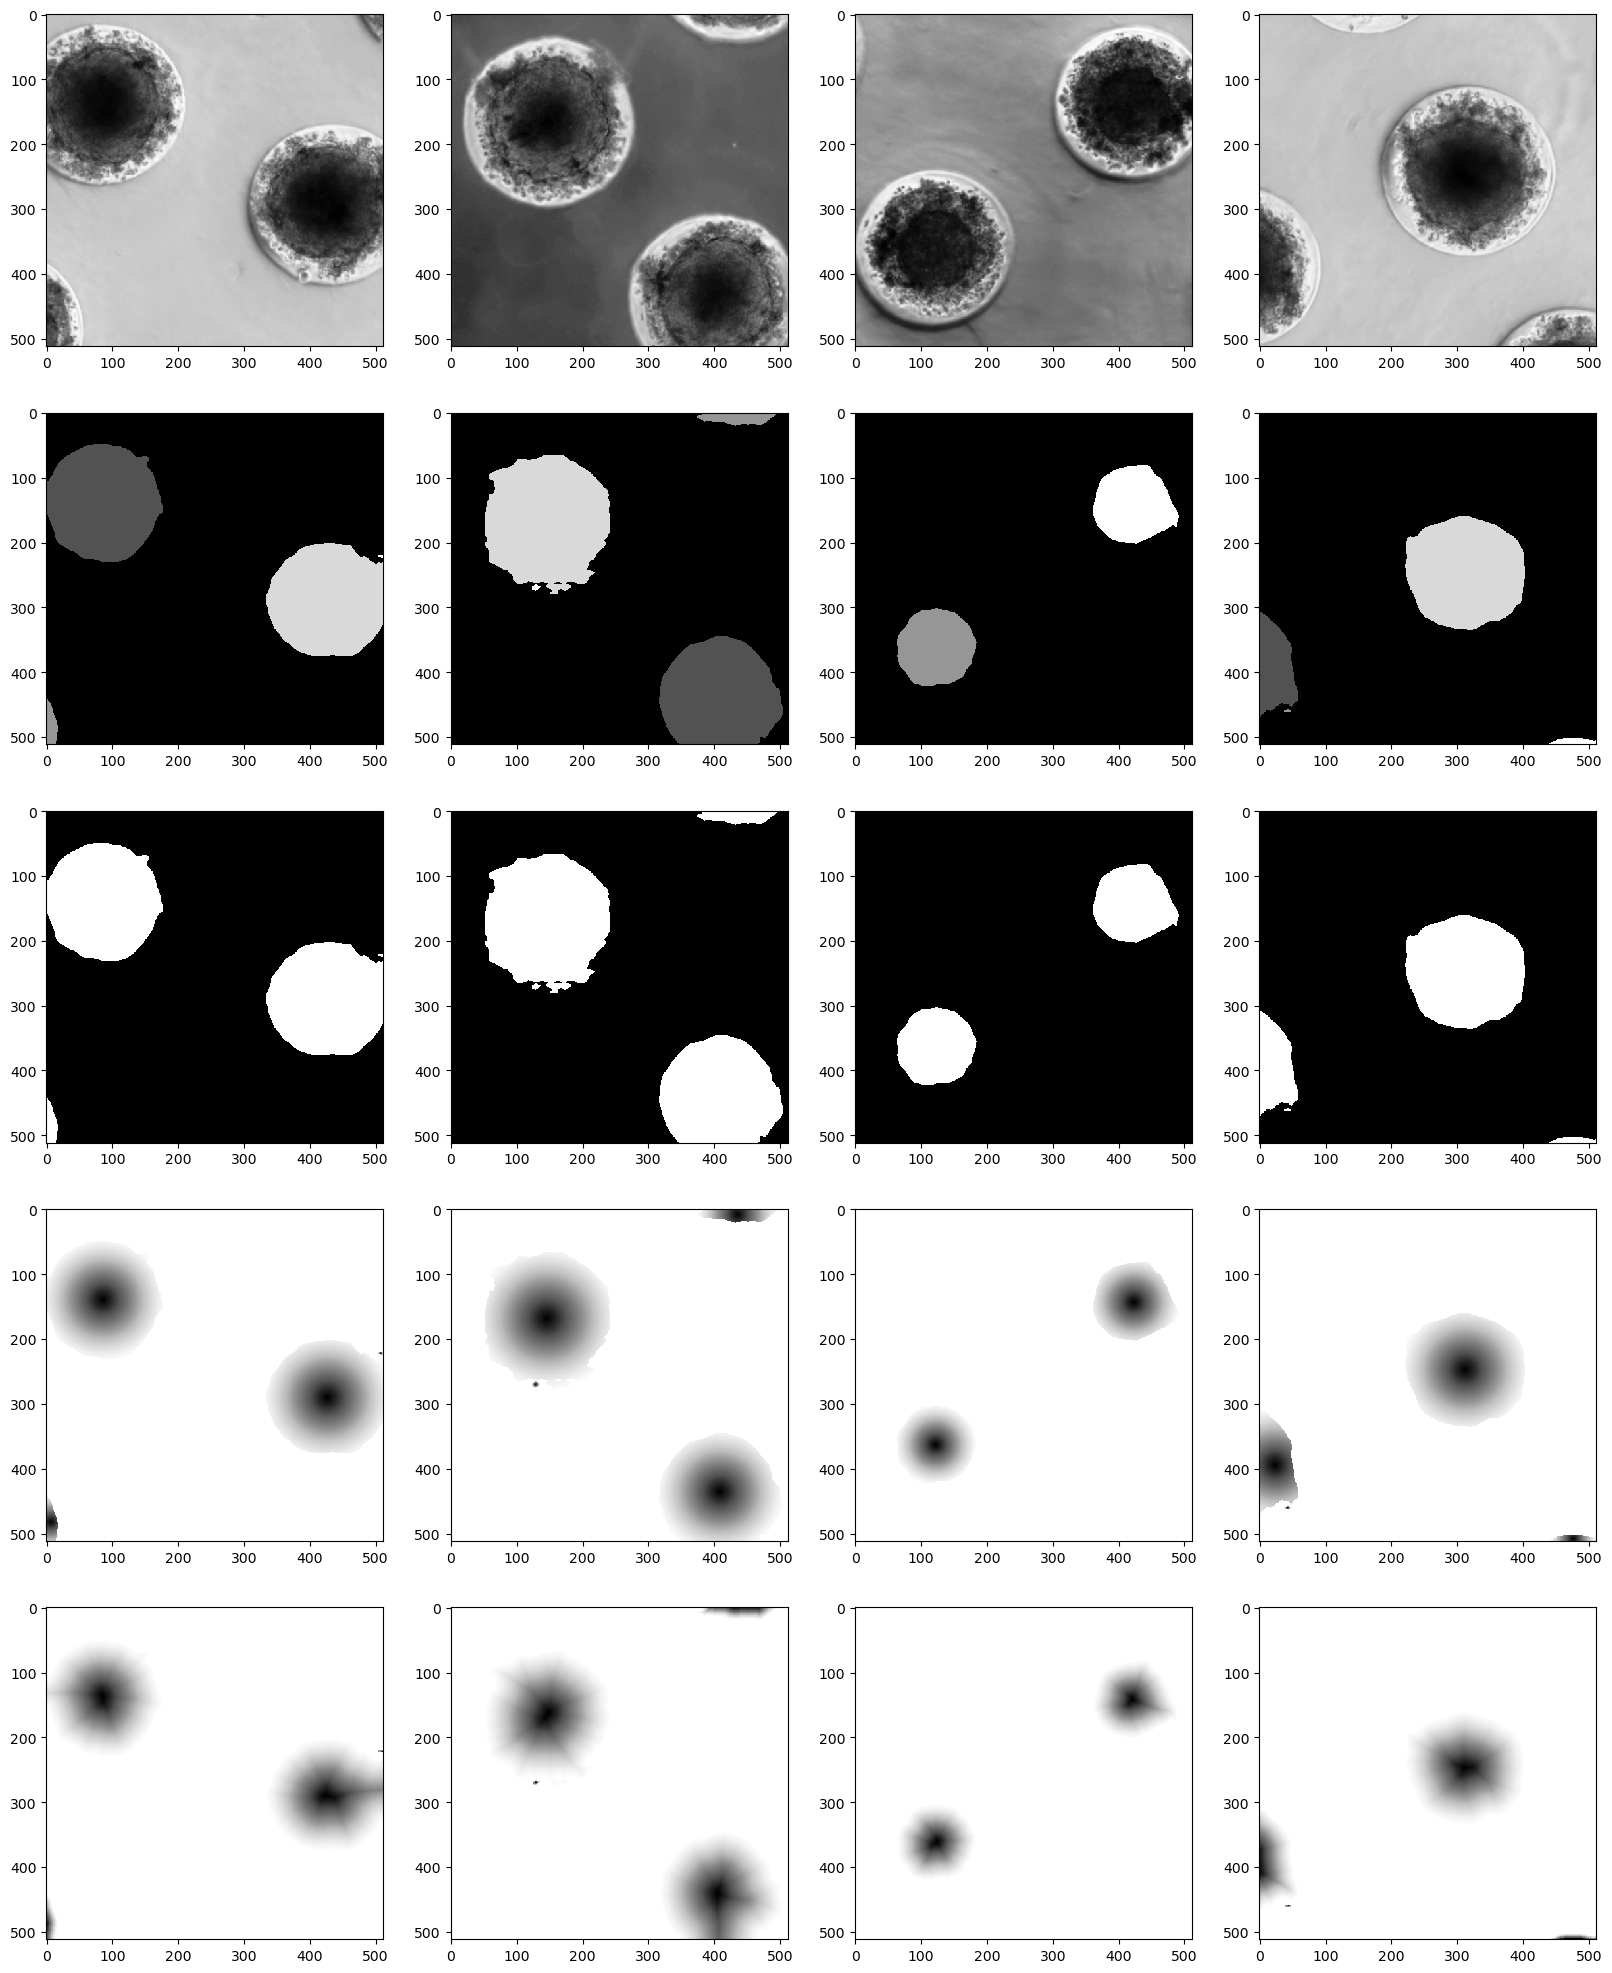

In [106]:
# Let's check how our samples look from the dataloader
check_loader(train_loader, 4, plt=True)

### Run the actual model finetuning

In [107]:
# All hyperparameters for training.
n_objects_per_batch = 10  # the number of objects per batch that will be sampled
device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
n_epochs = 50  # how long we train (in epochs)

# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = "vit_l"

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "sam_spheroid"

**NOTE**: The user needs to decide whether to finetune the Segment Anything model, or the `µsam`'s "finetuned microscopy models" for their dataset. Here, we finetune on the Segment Anything model for simplicity. For example, if you choose to finetune the model from the light microscopy generalist models, you need to update the `model_type` to `vit_b_lm` and it takes care of initializing the model with the desired weights)

In [108]:
# Run training
sam_training.train_sam(
    name=checkpoint_name,
    save_root=os.path.join(root_dir, "models"),
    model_type=model_type,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    n_objects_per_batch=n_objects_per_batch,
    with_segmentation_decoder=train_instance_segmentation,
    device=device,
)

/home/matlabuser/mambaforge/envs/micro-sam/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/home/matlabuser/mambaforge/envs/micro-sam/lib/python3.11/site-packages/torch_em/util/util.py:177: UserWarning: Constructor arguments for <class 'micro_sam.training.trainable_sam.TrainableSAM'> cannot be deduced.
For this object, empty constructor arguments will be used.
The trainer can probably not be correctly deserialized via 'DefaultTrainer.from_checkpoint'.
  warnings.warn(
/home/matlabuser/mambaforge/envs/micro-sam/lib/python3.11/site-packages/torch_em/util/util.py:177: UserWarning: Constructor arguments for <class 'torch_em.model.unetr.UNETR'> cannot be deduced.
For this object, empty constructor arguments will be used.
The trainer can probably not be correctly deserialized via 'DefaultTrainer.f

Start fitting for 4100 iterations /  50 epochs
with 82 iterations per epoch
Training with mixed precision



Epoch 0:   2%|▌                             | 82/4100 [02:00<1:36:53,  1.45s/it]
Epoch 1: average [s/it]: 1.470795, current metric: 0.206745, best metric: 0.2067
Epoch 1: average [s/it]: 1.470795, current metric: 0.206745, best metric: 0.2067
Epoch 1: average [s/it]: 1.470795, current metric: 0.206745, best metric: 0.2067
Epoch 1: average [s/it]: 1.470795, current metric: 0.206745, best metric: 0.2067
Epoch 1: average [s/it]: 1.470795, current metric: 0.206745, best metric: 0.2067
Epoch 1: average [s/it]: 1.470795, current metric: 0.206745, best metric: 0.2067
Epoch 1: average [s/it]: 1.470795, current metric: 0.206745, best metric: 0.2067
Epoch 1: average [s/it]: 1.470795, current metric: 0.206745, best metric: 0.2067
Epoch 1: average [s/it]: 1.470795, current metric: 0.206745, best metric: 0.2067
Epoch 1: average [s/it]: 1.470795, current metric: 0.206745, best metric: 0.2067
Epoch 1: average [s/it]: 1.470795, current metric: 0.206745, best metric: 0.2067
Epoch 1: average [s/it]: 1.

Stopping training because there has been no improvement for 10 epochs
Finished training after 17 epochs / 1476 iterations.
The best epoch is number 6.


In [110]:
# Let's spot our best checkpoint and download it to get started with the annotation tool
best_checkpoint = os.path.join("models", "checkpoints", checkpoint_name, "best.pt")

# # Download link is automatically generated for the best model.
print("Click here\u2193")
FileLink(best_checkpoint)

Click here↓


/home/matlabuser/Downloads/models/checkpoints/sam_spheroid/best.pt

### Let's run the automatic instance segmentation (AIS)

In [111]:
def run_automatic_instance_segmentation(image, checkpoint_path, model_type="vit_b_lm", device=None):
    """Automatic Instance Segmentation by training an additional instance decoder in SAM.

    NOTE: It is supported only for `µsam` models.
    
    Args:
        image: The input image.
        model_type: The choice of the `µsam` model.
        
    Returns:
        The instance segmentation.
    """
    # Step 1: Initialize the model attributes using the finetuned µsam model weights.
    #   - the 'predictor' object for generating predictions using the Segment Anything model.
    #   - the 'decoder' backbone (for AIS).
    predictor, decoder = get_predictor_and_decoder(
        model_type=model_type,  # choice of the Segment Anything model
        checkpoint_path=checkpoint_path,  # overwrite to pass our own finetuned model
        device=device,  # the device to run the model inference
    )
    
    # Step 2: Computation of the image embeddings from the vision transformer-based image encoder.
    image_embeddings = util.precompute_image_embeddings(
        predictor=predictor,  # the predictor object responsible for generating predictions
        input_=image,  # the input image
        ndim=2,  # number of input dimensions
    )
    
    # Step 3: Combining the decoder with the Segment Anything backbone for automatic instance segmentation.
    ais = InstanceSegmentationWithDecoder(predictor, decoder)
    
    # Step 4: Initializing the precomputed image embeddings to perform faster automatic instance segmentation.
    ais.initialize(
        image=image,  # the input image
        image_embeddings=image_embeddings,  # precomputed image embeddings
    )

    # Step 5: Getting automatic instance segmentations for the given image and applying the relevant post-processing steps.
    prediction = ais.generate()
    prediction = mask_data_to_segmentation(prediction, with_background=True)
    
    return prediction

In [68]:
zip_path = os.path.join(root_dir, "data", "DIC-C2DH-HeLa-test.zip")
!wget http://data.celltrackingchallenge.net/test-datasets/DIC-C2DH-HeLa.zip -O $zip_path
    
trg_dir = os.path.join(root_dir, "data", "test")
os.makedirs(trg_dir, exist_ok=True)
!unzip $zip_path -d trg_dir

--2024-07-23 10:06:20--  http://data.celltrackingchallenge.net/test-datasets/DIC-C2DH-HeLa.zip
Resolving data.celltrackingchallenge.net (data.celltrackingchallenge.net)... 147.251.52.183
Connecting to data.celltrackingchallenge.net (data.celltrackingchallenge.net)|147.251.52.183|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://data.celltrackingchallenge.net/test-datasets/DIC-C2DH-HeLa.zip [following]
--2024-07-23 10:06:20--  https://data.celltrackingchallenge.net/test-datasets/DIC-C2DH-HeLa.zip
Connecting to data.celltrackingchallenge.net (data.celltrackingchallenge.net)|147.251.52.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42728352 (41M) [application/zip]
Saving to: ‘data/DIC-C2DH-HeLa-test.zip’

data/DIC-C2DH-HeLa- 100%[===================>]  40,75M  12,3MB/s    in 3,4s    

2024-07-23 10:06:24 (11,9 MB/s) - ‘data/DIC-C2DH-HeLa-test.zip’ saved [42728352/42728352]

Archive:  data/DIC-C2DH-HeLa-test.zip


Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.36it/s]


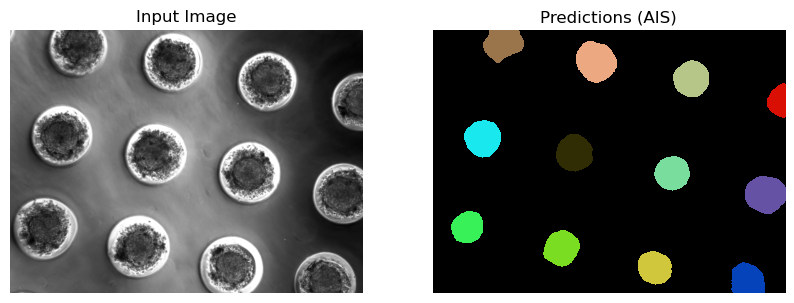


Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.43it/s]


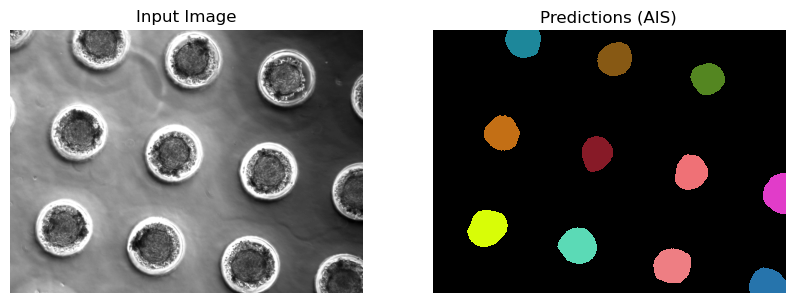


Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.44it/s]


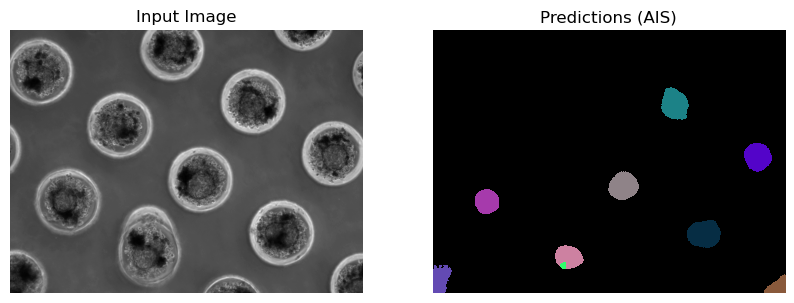


Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.44it/s]


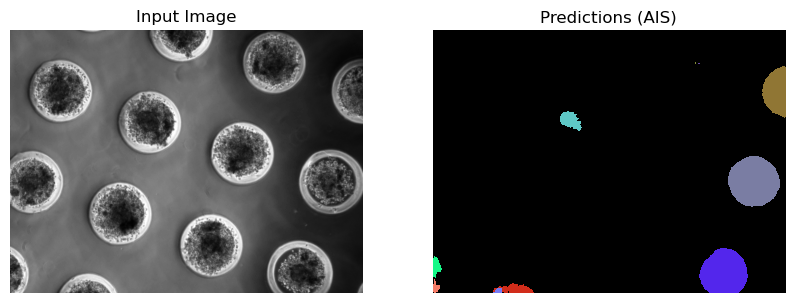


Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.43it/s]


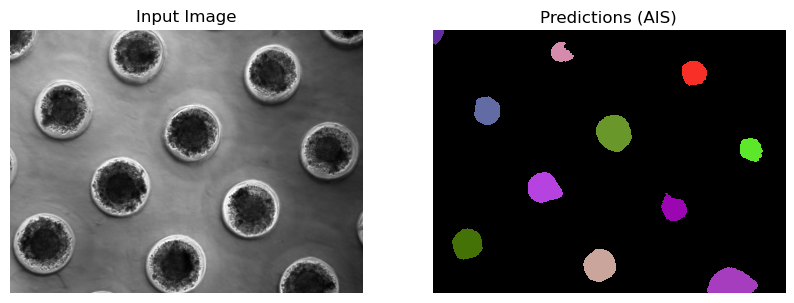


Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.43it/s]


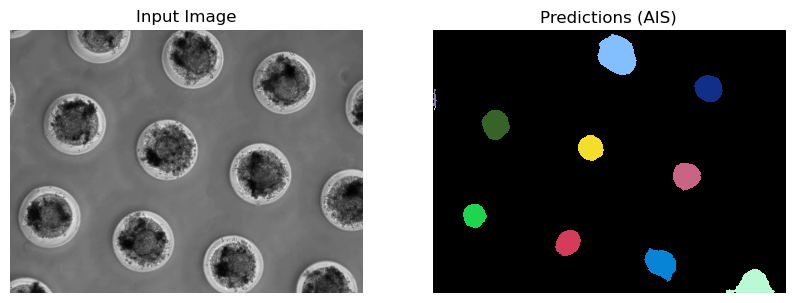


Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.44it/s]


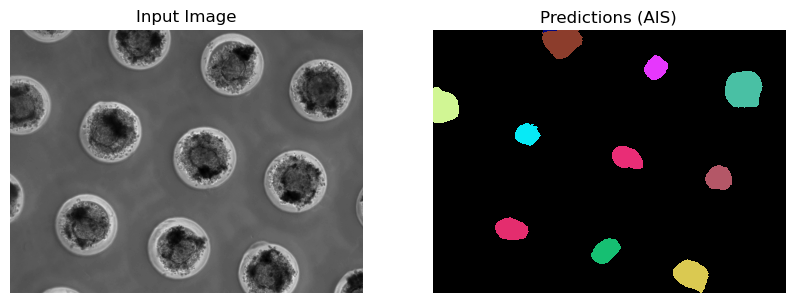


Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.40it/s]


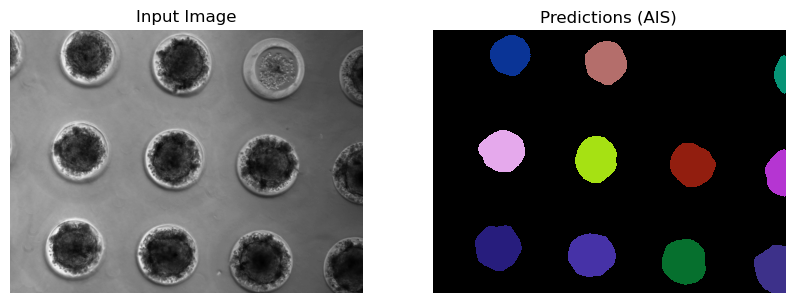


Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.42it/s]


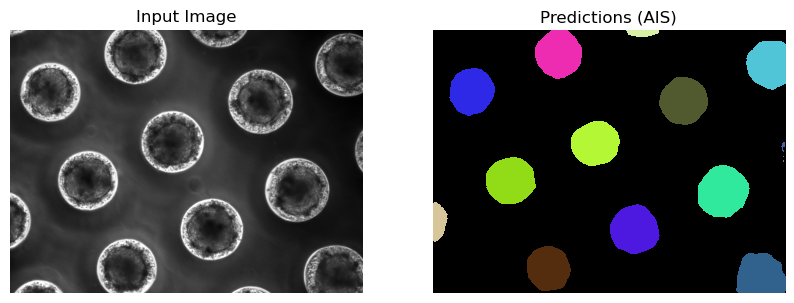


Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.34it/s]


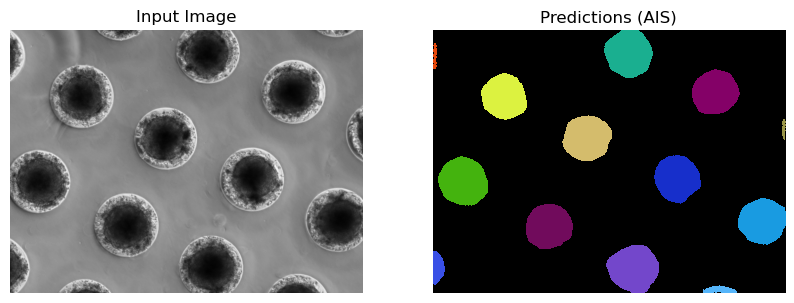

In [112]:
assert os.path.exists(best_checkpoint), "Please train the model first to run inference on the finetuned model."
assert train_instance_segmentation is True, "Oops. You didn't opt for finetuning using the decoder-based automatic instance segmentation."

# # Let's check the first 5 images. Feel free to comment out the line below to run inference on all images.
image_paths = image_paths[:10]

for image_path in image_paths:
    image = imageio.imread(image_path)
    
    # Predicted instances
    prediction = run_automatic_instance_segmentation(
        image=image,
        checkpoint_path=best_checkpoint,
        model_type=model_type,
        device=device
    )

    # Visualize the predictions
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(image, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Input Image")

    ax[1].imshow(prediction, cmap=get_random_colors(prediction), interpolation="nearest")
    ax[1].axis("off")
    ax[1].set_title("Predictions (AIS)")

    plt.show()
    plt.close()

Found 104 images.

Processing image 1/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/CS5 mold 2 2.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.34it/s]


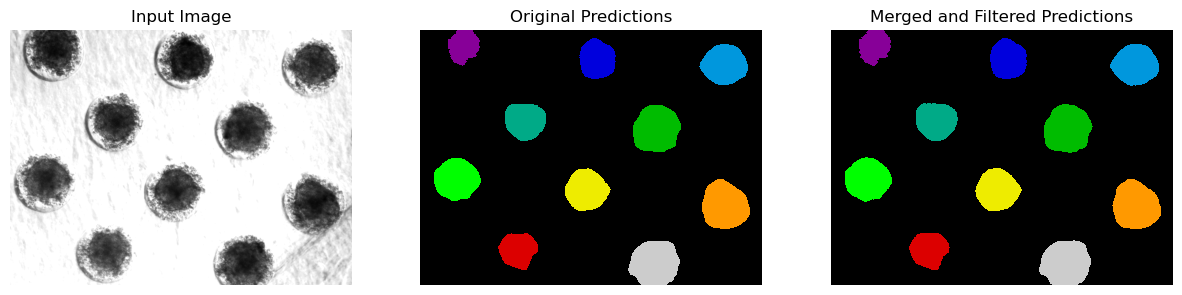

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/labelIm_CS5 mold 2 2.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/measurements_CS5 mold 2 2.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/ROIs_CS5 mold 2 2.tif.zip

Processing image 2/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/CS5 mold 2 7.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.36it/s]


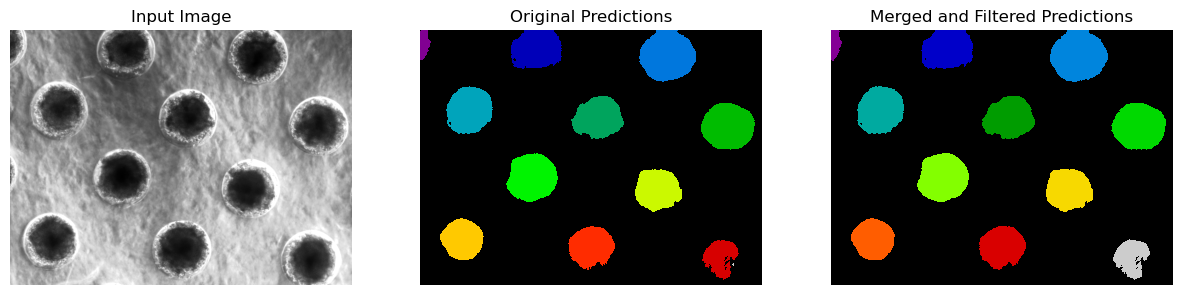

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/labelIm_CS5 mold 2 7.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/measurements_CS5 mold 2 7.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/ROIs_CS5 mold 2 7.tif.zip

Processing image 3/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/CS5 mold 2 8.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.33it/s]


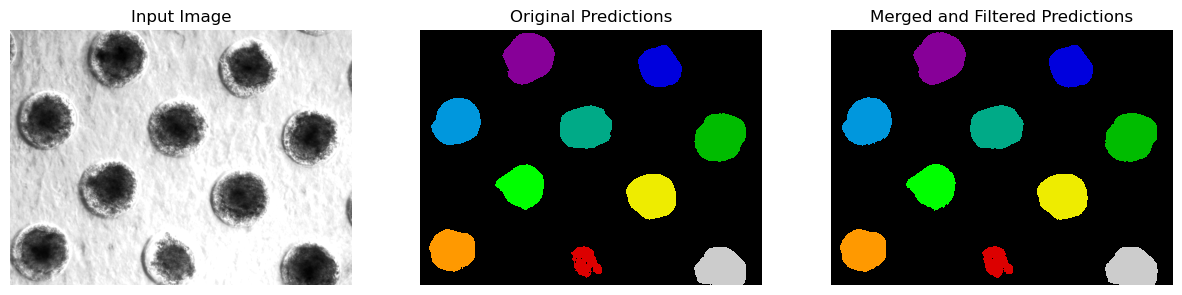

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/labelIm_CS5 mold 2 8.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/measurements_CS5 mold 2 8.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/ROIs_CS5 mold 2 8.tif.zip

Processing image 4/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/CS5 mold 2 5.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.45it/s]


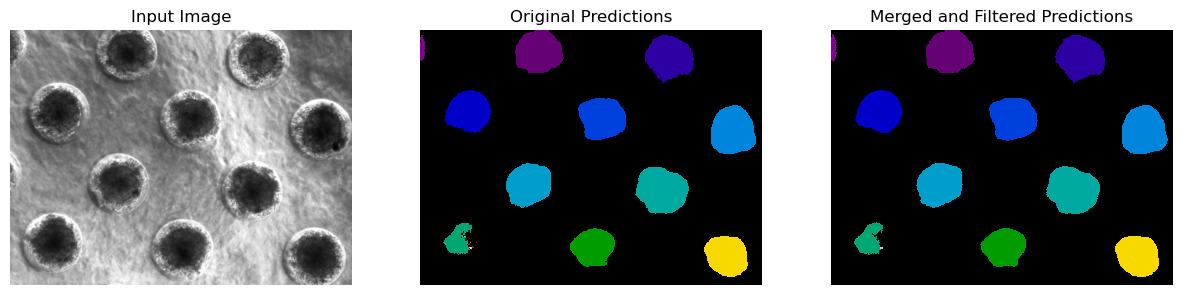

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/labelIm_CS5 mold 2 5.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/measurements_CS5 mold 2 5.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/ROIs_CS5 mold 2 5.tif.zip

Processing image 5/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/CS5 mold 2 4.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.43it/s]


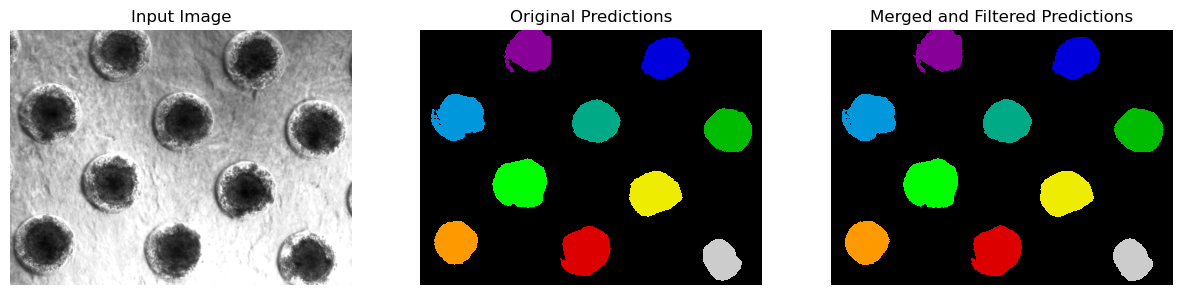

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/labelIm_CS5 mold 2 4.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/measurements_CS5 mold 2 4.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/ROIs_CS5 mold 2 4.tif.zip

Processing image 6/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/CS5 mold 2 1.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.34it/s]


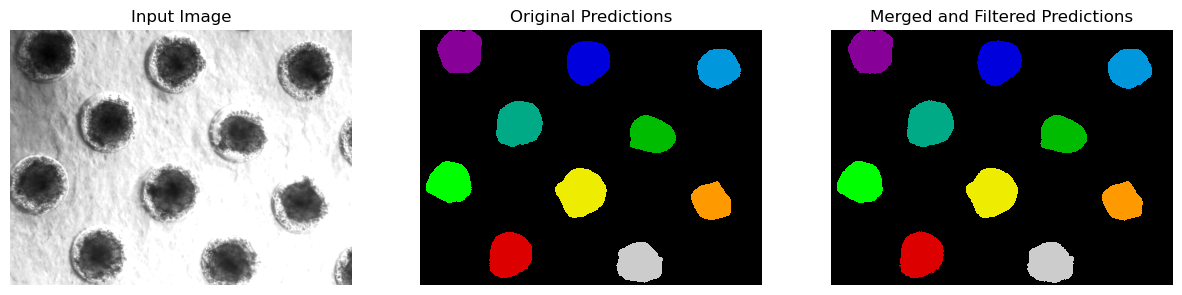

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/labelIm_CS5 mold 2 1.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/measurements_CS5 mold 2 1.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/ROIs_CS5 mold 2 1.tif.zip

Processing image 7/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/CS5 mold 2 3.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.34it/s]


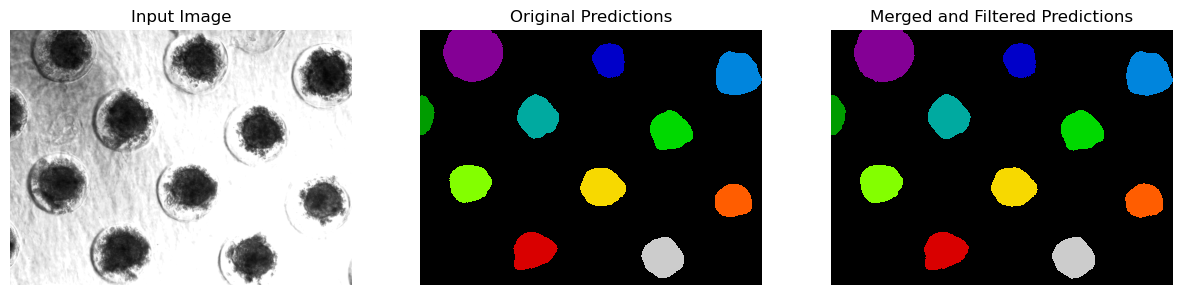

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/labelIm_CS5 mold 2 3.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/measurements_CS5 mold 2 3.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/ROIs_CS5 mold 2 3.tif.zip

Processing image 8/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/CS5 mold 2 6.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.37it/s]


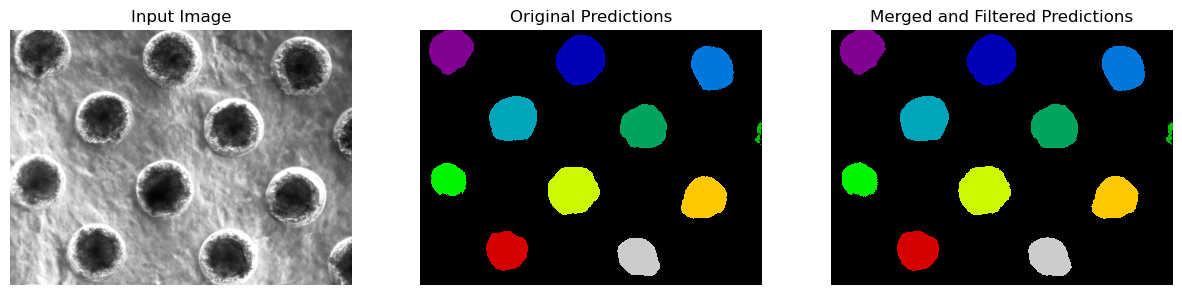

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/labelIm_CS5 mold 2 6.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/measurements_CS5 mold 2 6.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 2/ROIs_CS5 mold 2 6.tif.zip

Processing image 9/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/CS5 mold 3 2.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.36it/s]


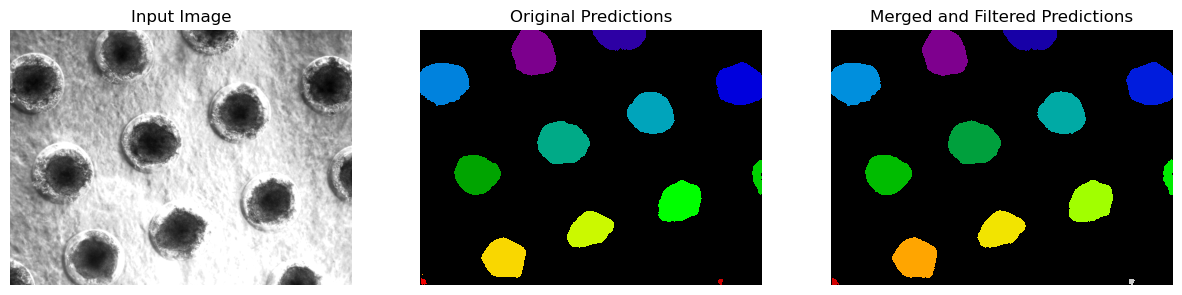

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/labelIm_CS5 mold 3 2.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/measurements_CS5 mold 3 2.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/ROIs_CS5 mold 3 2.tif.zip

Processing image 10/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/CS5 mold 3 4.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.33it/s]


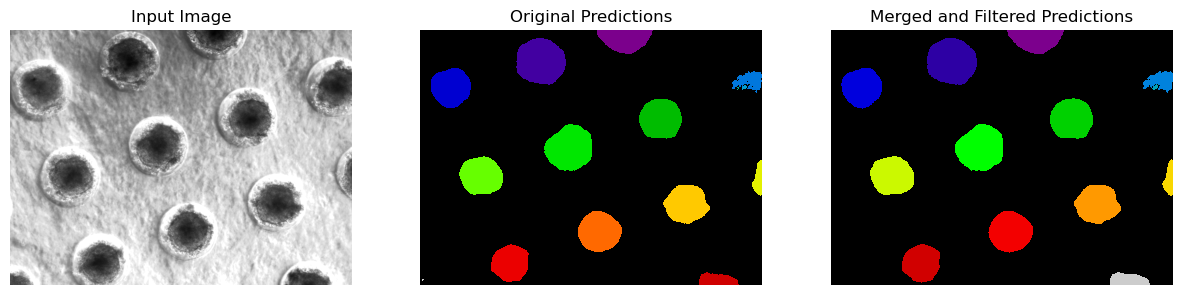

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/labelIm_CS5 mold 3 4.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/measurements_CS5 mold 3 4.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/ROIs_CS5 mold 3 4.tif.zip

Processing image 11/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/CS5 mold 3 7.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.32it/s]


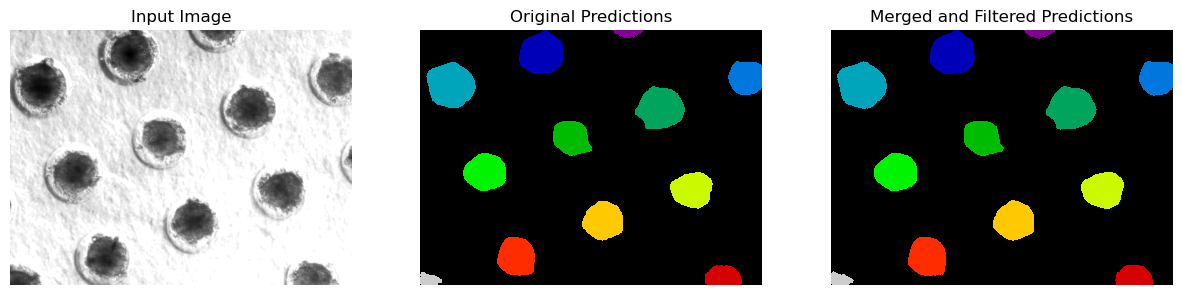

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/labelIm_CS5 mold 3 7.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/measurements_CS5 mold 3 7.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/ROIs_CS5 mold 3 7.tif.zip

Processing image 12/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/CS5 mold 3 5.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.41it/s]


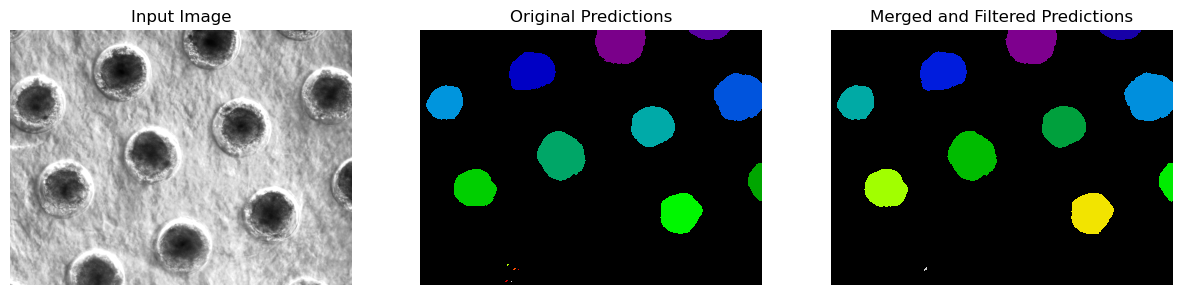

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/labelIm_CS5 mold 3 5.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/measurements_CS5 mold 3 5.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/ROIs_CS5 mold 3 5.tif.zip

Processing image 13/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/CS5 mold 3 6.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.46it/s]


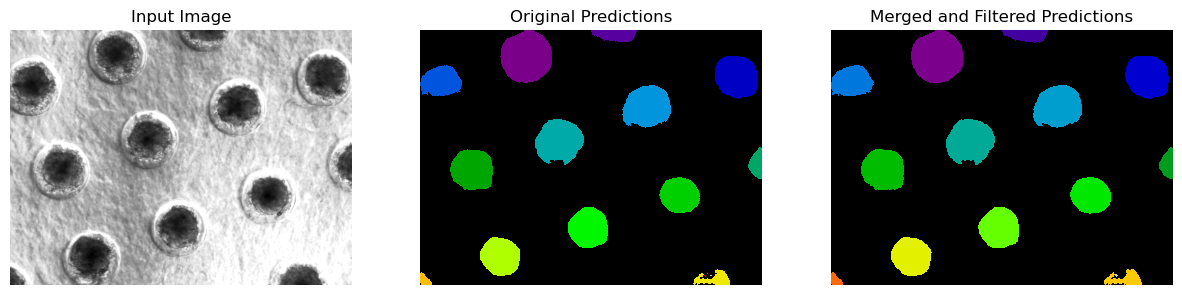

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/labelIm_CS5 mold 3 6.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/measurements_CS5 mold 3 6.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/ROIs_CS5 mold 3 6.tif.zip

Processing image 14/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/CS5 mold 3 1.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.35it/s]


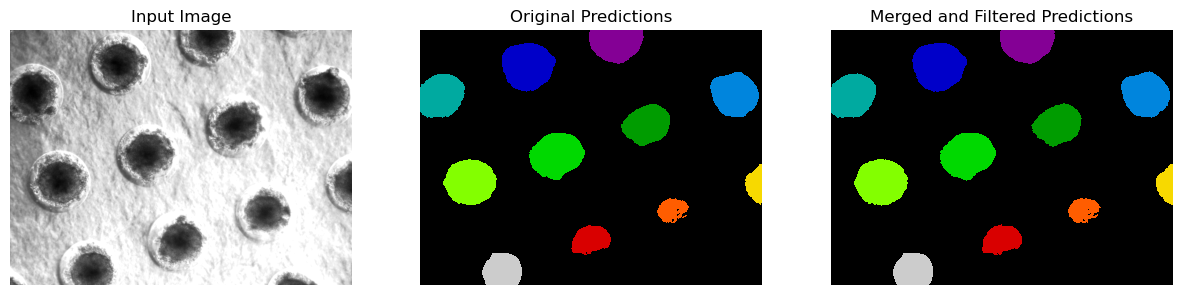

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/labelIm_CS5 mold 3 1.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/measurements_CS5 mold 3 1.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/ROIs_CS5 mold 3 1.tif.zip

Processing image 15/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/CS5 mold 3 8.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.43it/s]


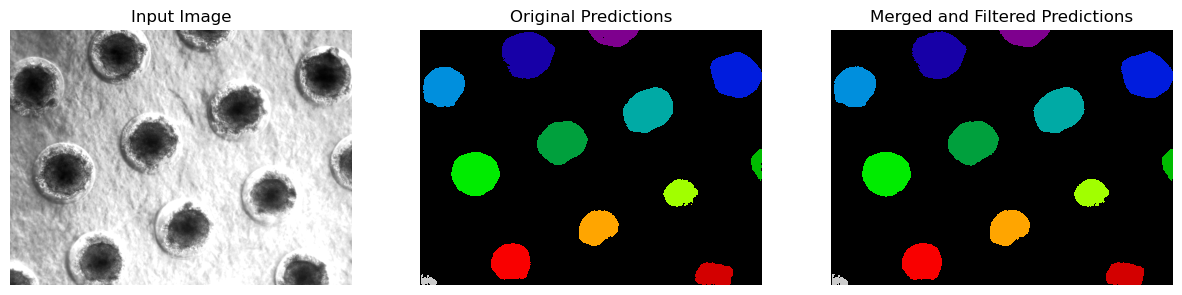

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/labelIm_CS5 mold 3 8.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/measurements_CS5 mold 3 8.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/ROIs_CS5 mold 3 8.tif.zip

Processing image 16/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/CS5 mold 3 3.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.37it/s]


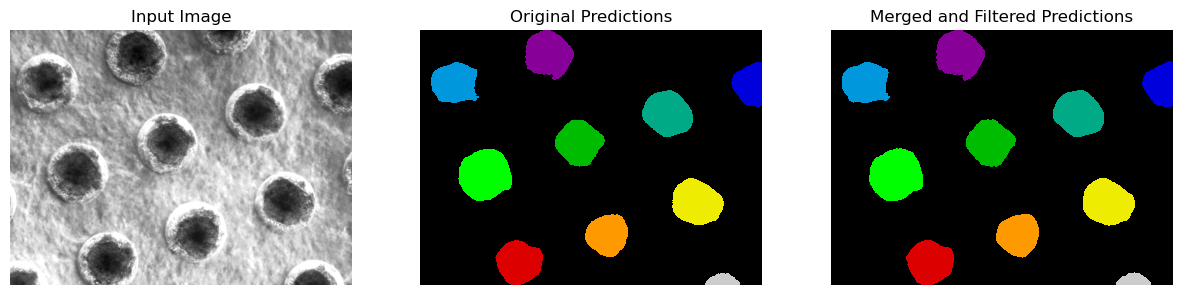

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/labelIm_CS5 mold 3 3.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/measurements_CS5 mold 3 3.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d4 3/ROIs_CS5 mold 3 3.tif.zip

Processing image 17/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/CS5 mold 1 3.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.42it/s]


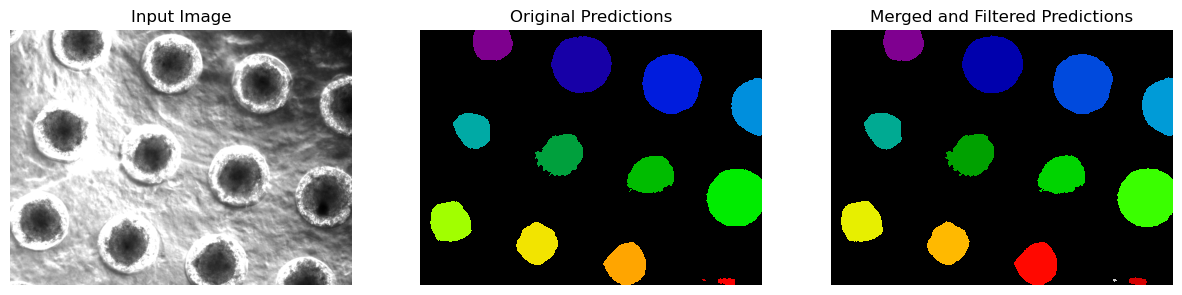

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/labelIm_CS5 mold 1 3.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/measurements_CS5 mold 1 3.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/ROIs_CS5 mold 1 3.tif.zip

Processing image 18/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/CS5 mold 1 10.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.40it/s]


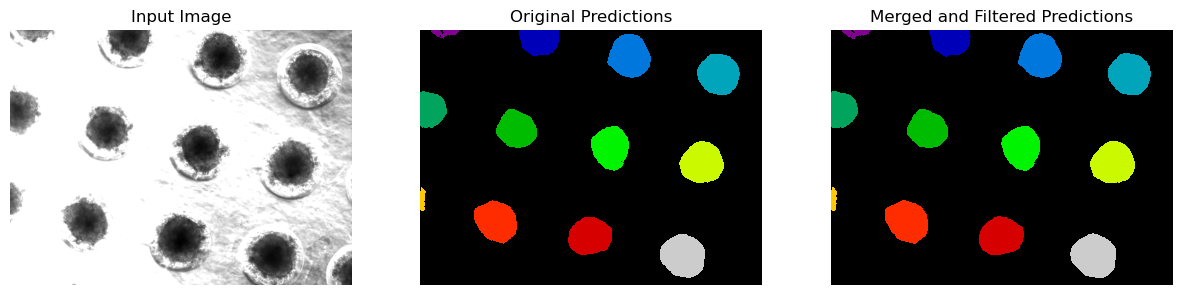

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/labelIm_CS5 mold 1 10.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/measurements_CS5 mold 1 10.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/ROIs_CS5 mold 1 10.tif.zip

Processing image 19/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/CS5 mold 1 5.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.31it/s]


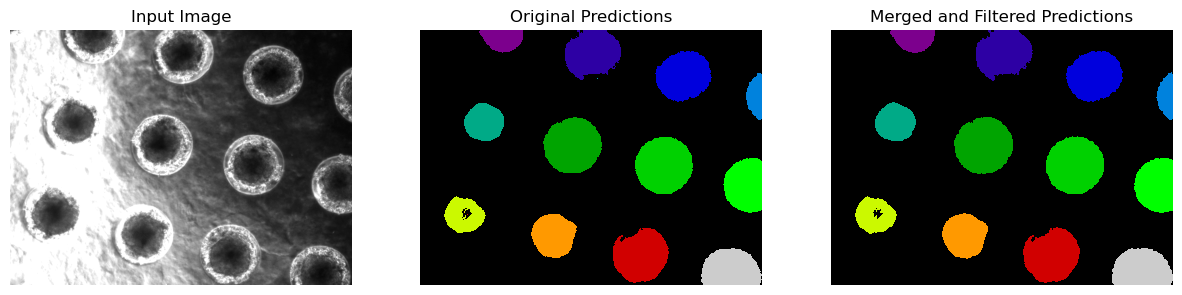

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/labelIm_CS5 mold 1 5.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/measurements_CS5 mold 1 5.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/ROIs_CS5 mold 1 5.tif.zip

Processing image 20/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/CS5 mold 1 4.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.35it/s]


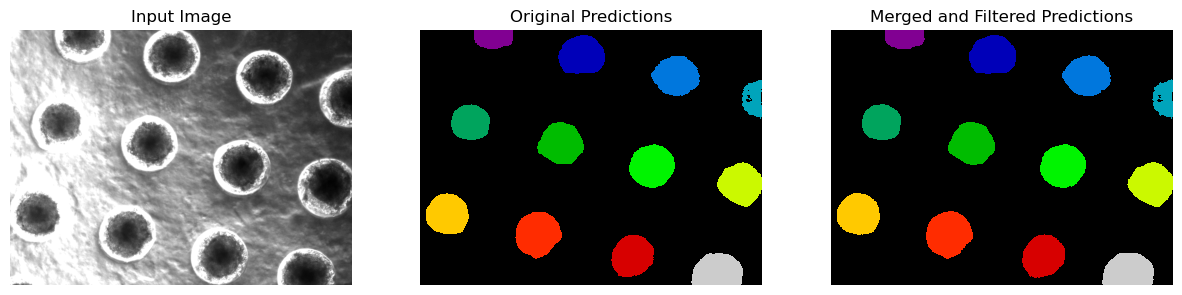

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/labelIm_CS5 mold 1 4.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/measurements_CS5 mold 1 4.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/ROIs_CS5 mold 1 4.tif.zip

Processing image 21/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/CS5 mold 1 6.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.31it/s]


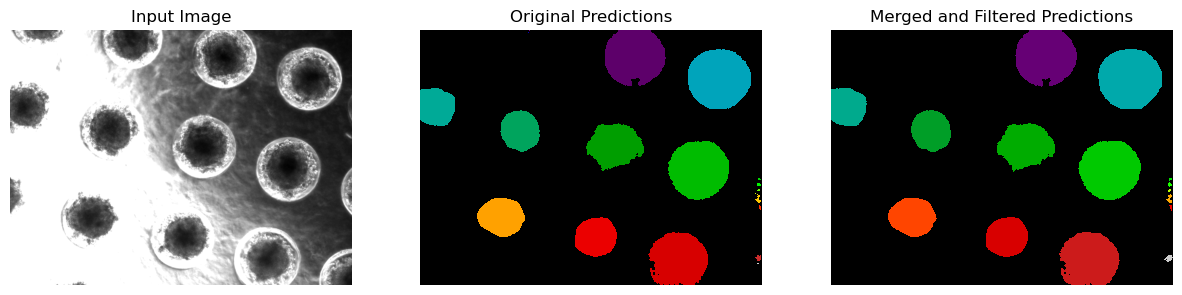

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/labelIm_CS5 mold 1 6.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/measurements_CS5 mold 1 6.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/ROIs_CS5 mold 1 6.tif.zip

Processing image 22/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/CS5 mold 1 1.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.35it/s]


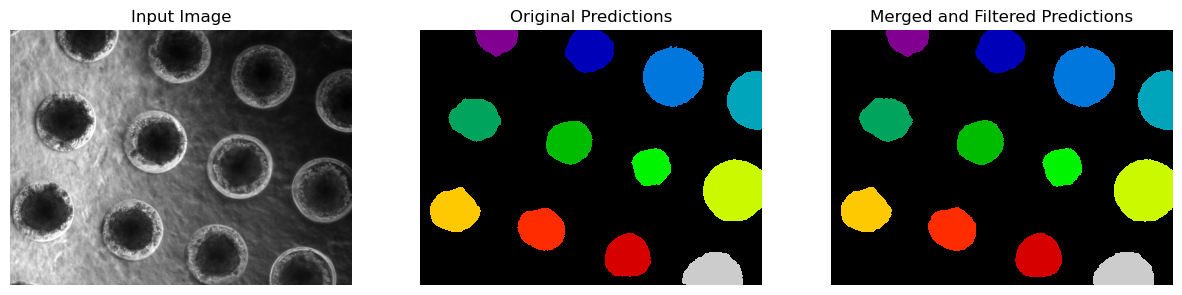

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/labelIm_CS5 mold 1 1.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/measurements_CS5 mold 1 1.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/ROIs_CS5 mold 1 1.tif.zip

Processing image 23/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/CS5 mold 1 8.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.35it/s]


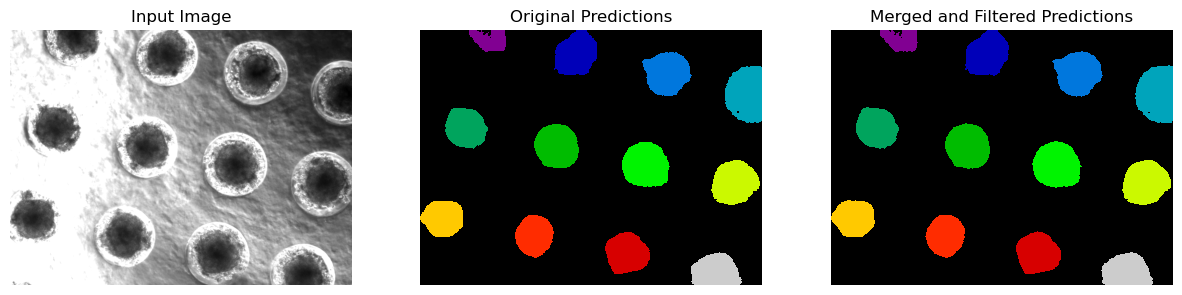

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/labelIm_CS5 mold 1 8.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/measurements_CS5 mold 1 8.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/ROIs_CS5 mold 1 8.tif.zip

Processing image 24/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/CS5 mold 1 9.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.34it/s]


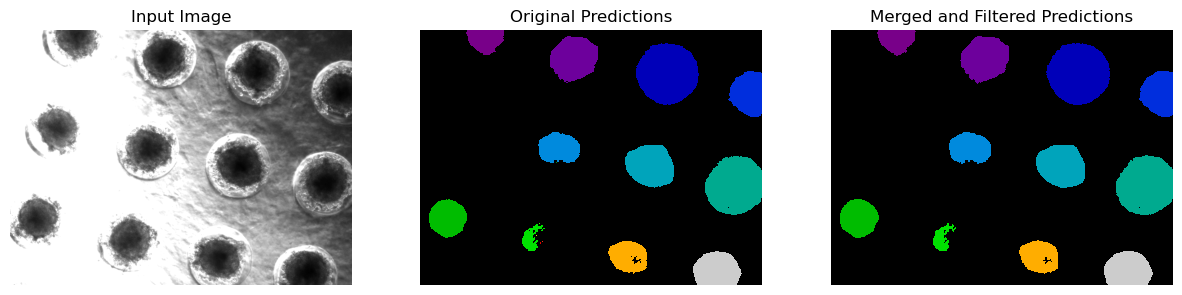

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/labelIm_CS5 mold 1 9.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/measurements_CS5 mold 1 9.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/ROIs_CS5 mold 1 9.tif.zip

Processing image 25/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/CS5 mold 1 7.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.40it/s]


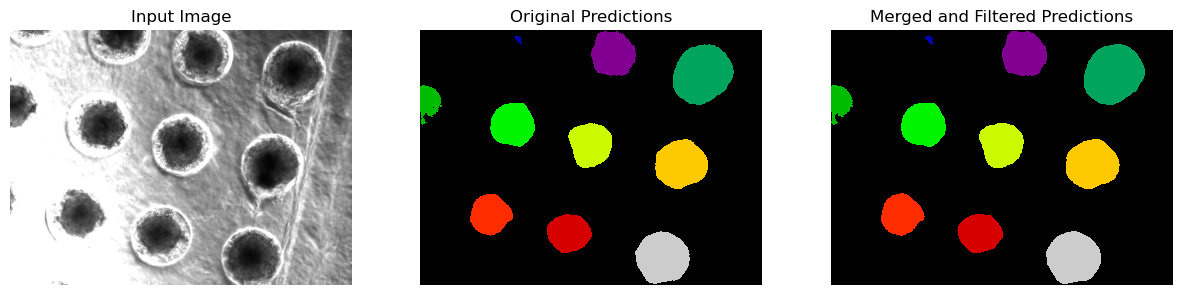

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/labelIm_CS5 mold 1 7.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/measurements_CS5 mold 1 7.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/ROIs_CS5 mold 1 7.tif.zip

Processing image 26/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/CS5 mold 1 2.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.44it/s]


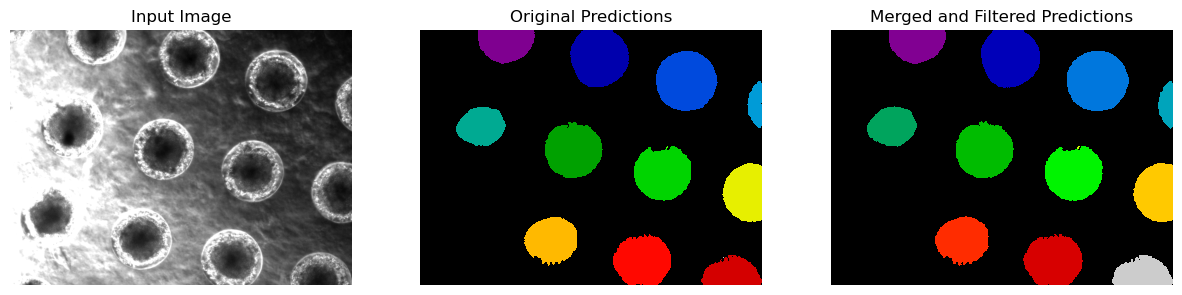

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/labelIm_CS5 mold 1 2.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/measurements_CS5 mold 1 2.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 1/ROIs_CS5 mold 1 2.tif.zip

Processing image 27/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/CS5 mold 3 2.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.43it/s]


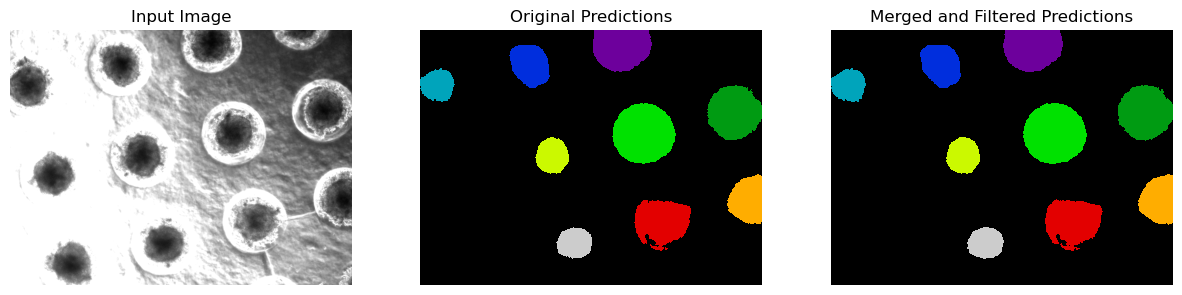

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/labelIm_CS5 mold 3 2.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/measurements_CS5 mold 3 2.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/ROIs_CS5 mold 3 2.tif.zip

Processing image 28/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/CS5 mold 3 4.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.39it/s]


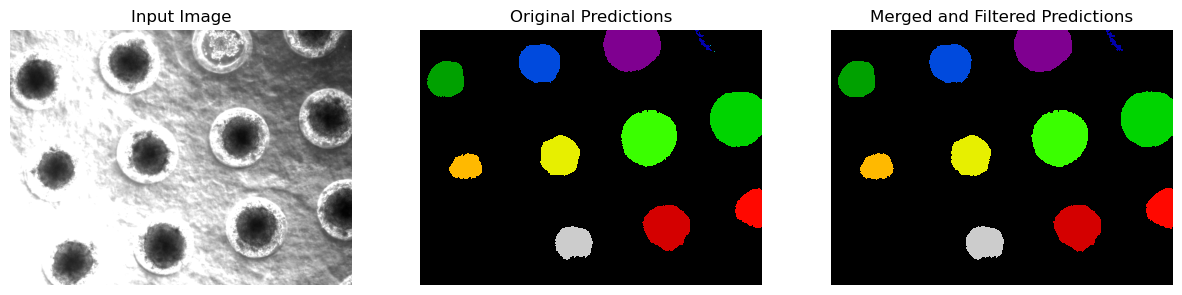

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/labelIm_CS5 mold 3 4.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/measurements_CS5 mold 3 4.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/ROIs_CS5 mold 3 4.tif.zip

Processing image 29/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/CS5 mold 3 7.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.38it/s]


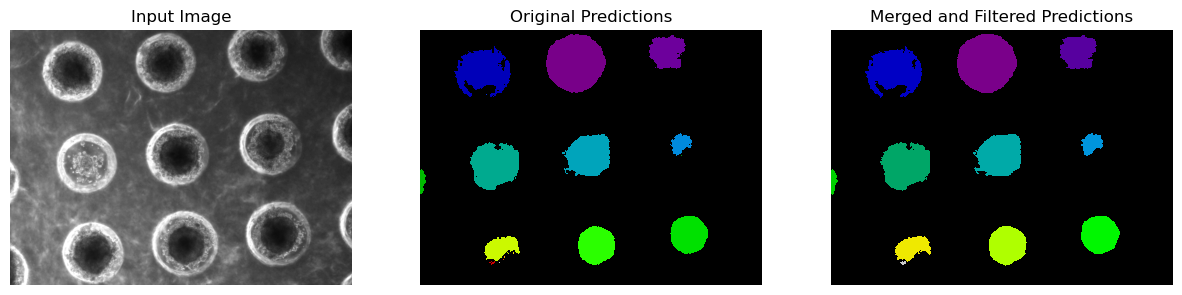

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/labelIm_CS5 mold 3 7.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/measurements_CS5 mold 3 7.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/ROIs_CS5 mold 3 7.tif.zip

Processing image 30/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/CS5 mold 3 9.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.38it/s]


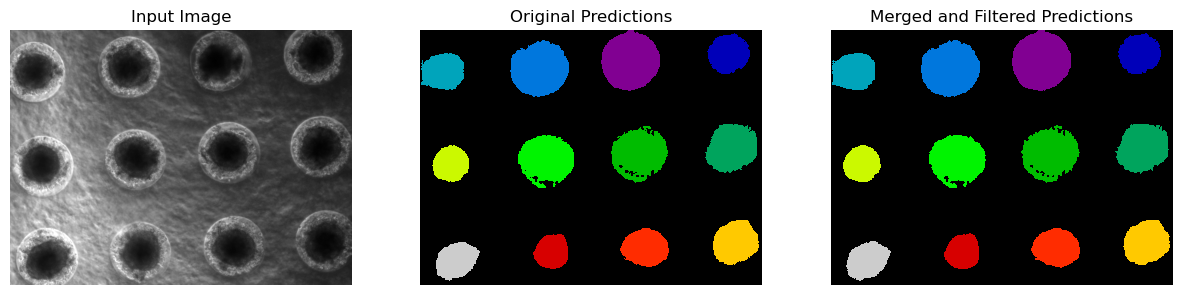

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/labelIm_CS5 mold 3 9.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/measurements_CS5 mold 3 9.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/ROIs_CS5 mold 3 9.tif.zip

Processing image 31/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/CS5 mold 3 5.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.45it/s]


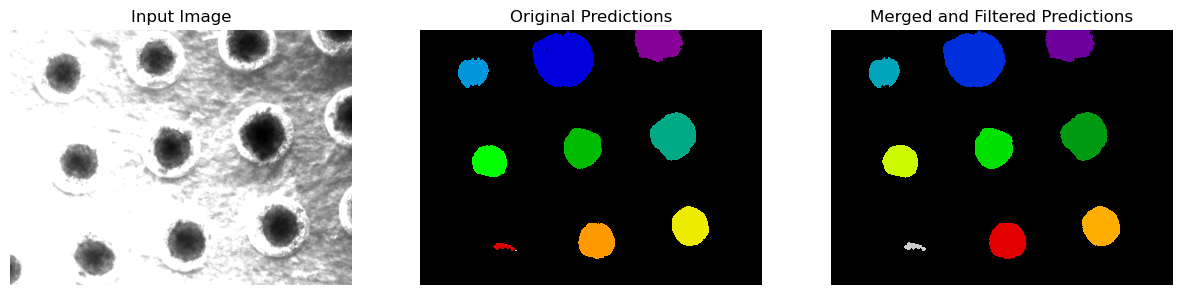

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/labelIm_CS5 mold 3 5.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/measurements_CS5 mold 3 5.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/ROIs_CS5 mold 3 5.tif.zip

Processing image 32/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/CS5 mold 3 6.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.34it/s]


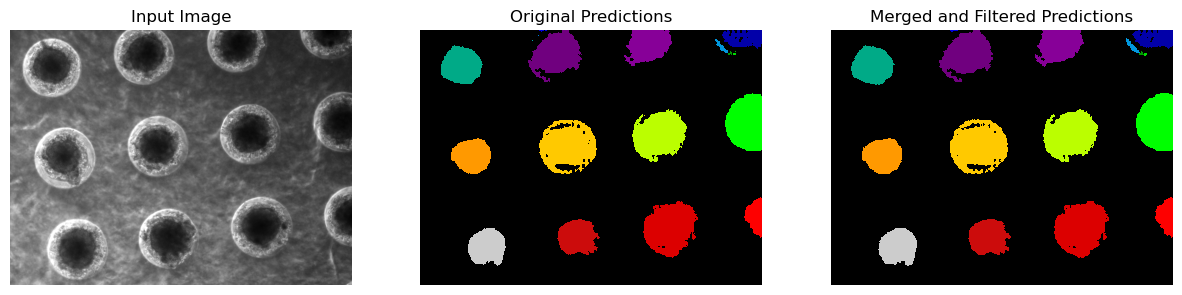

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/labelIm_CS5 mold 3 6.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/measurements_CS5 mold 3 6.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/ROIs_CS5 mold 3 6.tif.zip

Processing image 33/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/CS5 mold 3 1.tif
Image shape: (1040, 1392)
Image dtype: uint8



Compute Image Embeddings 2D.: 100%|███████████████| 1/1 [00:00<00:00,  2.33it/s]


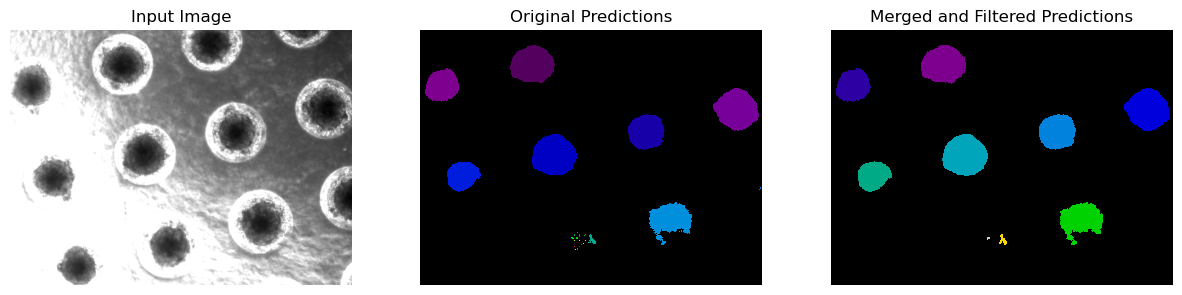

Saved: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/labelIm_CS5 mold 3 1.tif
Saved measurements: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/measurements_CS5 mold 3 1.tif.csv
Saved ROIs: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/ROIs_CS5 mold 3 1.tif.zip

Processing image 34/104:
File: /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5/d7 3/CS5 mold 3 8.tif
Image shape: (1040, 1392)
Image dtype: uint8


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from glob import glob
from skimage import measure, morphology, segmentation
from skimage.measure import regionprops, label
import pandas as pd
import math
from roifile import ImagejRoi, roiwrite
from scipy import ndimage

def get_image_paths(folder_path):
    return [
        f for f in glob(os.path.join(folder_path, '**', '*.tif'), recursive=True)
        if 'mask' not in os.path.basename(f) and 'labelIm' not in os.path.basename(f)
    ]

def merge_overlapping_labels(label_image):
    # Check if the image is 2D or 3D
    if label_image.ndim == 2:
        selem = morphology.disk(1)
    elif label_image.ndim == 3:
        selem = morphology.ball(1)
    else:
        raise ValueError("Unsupported image dimension. Expected 2D or 3D image.")

    # Dilate each label to find overlaps
    dilated = morphology.dilation(label_image, selem)
    
    # Find overlapping regions
    overlap = (dilated > 0) & (label_image == 0)
    
    # Assign overlapping regions to the nearest label
    overlap_labels = segmentation.watershed(image=np.zeros_like(label_image), 
                                            markers=label_image, 
                                            mask=dilated > 0)
    
    # Relabel the image
    return label(overlap_labels)

def filter_small_labels(label_image, min_size=100):
    return morphology.remove_small_objects(label_image, min_size=min_size)


def create_outline_roi(label_region):
    # Find contours of the region
    contours = measure.find_contours(label_region.image, 0.5)
    
    if contours:
        # Use the first contour (usually the outer boundary)
        contour = contours[0]
        
        # Add the offset to the contour coordinates
        contour[:, 0] += label_region.bbox[0]
        contour[:, 1] += label_region.bbox[1]
        
        # Swap x and y coordinates to match ImageJ's expectation
        contour = contour[:, [1, 0]]
        
        # Create an outline ROI
        roi = ImagejRoi.frompoints(contour.astype(np.float32))
        roi.name = f"Label_{label_region.label}"
        
        return roi
    
    return None



def analyze_label_image(label_image):
    props = regionprops(label_image)
    measurements = []
    rois = []
    for prop in props:
        area = prop.area
        perimeter = prop.perimeter
        height = prop.bbox[2] - prop.bbox[0]
        width = prop.bbox[3] - prop.bbox[1]
        diameter = prop.equivalent_diameter
        volume = (4/3) * math.pi * (diameter/2)**3  # Assuming spherical shape

        measurements.append({
            'Label': prop.label,
            'Area': area,
            'Height': height,
            'Width': width,
            'Perimeter': perimeter,
            'Diameter': diameter,
            'Volume': volume
        })

        # Create ROI for ImageJ
        roi = create_outline_roi(prop)
        if roi:
            rois.append(roi)

    return pd.DataFrame(measurements), rois


# Main script
input_folder = "/run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5"
#best_checkpoint = "path/to/your/best/checkpoint"  # Replace with actual path
#model_type = "your_model_type"  # Replace with actual model type
#device = "cuda"  # or "cpu"
#train_instance_segmentation = True  # Set this to True or False based on your setup

assert os.path.exists(best_checkpoint), "Please train the model first to run inference on the finetuned model."
assert train_instance_segmentation is True, "Oops. You didn't opt for finetuning using the decoder-based automatic instance segmentation."

image_paths = get_image_paths(input_folder)
print(f"Found {len(image_paths)} images.")

# Let's check the first 10 images. Feel free to change this number or comment out the line below to run inference on all images.
#image_paths = image_paths[:100]

for i, image_path in enumerate(image_paths):
    print(f"\nProcessing image {i+1}/{len(image_paths)}:")
    print(f"File: {image_path}")
    
    try:
        # Read the TIFF file
        image = tifffile.imread(image_path)
        
        print(f"Image shape: {image.shape}")
        print(f"Image dtype: {image.dtype}")
        
        # Run automatic instance segmentation
        prediction = run_automatic_instance_segmentation(
            image=image,
            checkpoint_path=best_checkpoint,
            model_type=model_type,
            device=device
        )
        
        # Ensure prediction is a label image
        if prediction.dtype != np.int32:
            prediction = label(prediction > 0)
        
        # Merge overlapping labels and filter small objects
        try:
            merged_prediction = merge_overlapping_labels(prediction)
            filtered_prediction = filter_small_labels(merged_prediction, min_size=100)
        except Exception as e:
            print(f"Warning: Error in merging or filtering. Using original prediction. Error: {str(e)}")
            filtered_prediction = prediction
        
        # Visualize the predictions
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image, cmap="gray")
        ax[0].axis("off")
        ax[0].set_title("Input Image")
        ax[1].imshow(prediction, cmap='nipy_spectral', interpolation="nearest")
        ax[1].axis("off")
        ax[1].set_title("Original Predictions")
        ax[2].imshow(filtered_prediction, cmap='nipy_spectral', interpolation="nearest")
        ax[2].axis("off")
        ax[2].set_title("Merged and Filtered Predictions")
        plt.show()
        plt.close()
        
        # Save the filtered prediction with "labelIm_" prefix
        output_filename = f"labelIm_{os.path.basename(image_path)}"
        output_path = os.path.join(os.path.dirname(image_path), output_filename)
        
        # Ensure the label image is saved as 16-bit unsigned integer
        filtered_prediction_16bit = filtered_prediction.astype(np.uint16)
        tifffile.imwrite(output_path, filtered_prediction_16bit, compression='zlib')
        print(f"Saved: {output_path}")

        # Analyze label image
        measurements_df, rois = analyze_label_image(filtered_prediction)

        # Save measurements
        measurements_path = os.path.join(os.path.dirname(image_path), f"measurements_{os.path.basename(image_path)}.csv")
        measurements_df.to_csv(measurements_path, index=False)
        print(f"Saved measurements: {measurements_path}")

        # Save ROIs
        roi_path = os.path.join(os.path.dirname(image_path), f"ROIs_{os.path.basename(image_path)}.zip")
        roiwrite(roi_path, rois)
        print(f"Saved ROIs: {roi_path}")
        
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

print("Done processing images.")

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

def read_csv_files(folder_path):
    csv_files = glob(os.path.join(folder_path, '**', 'measurements_*.csv'), recursive=True)
    data = []
    for file in csv_files:
        df = pd.read_csv(file)
        folder_name = os.path.basename(os.path.dirname(file))
        day, treatment = folder_name.split()
        df['Day'] = int(day[1:])
        df['Treatment'] = int(treatment)
        data.append(df)
    return pd.concat(data, ignore_index=True)

def create_combined_plots(data, output_folder, normalized=False):
    measurements = ['Area', 'Height', 'Width', 'Perimeter', 'Diameter', 'Volume']
    days = sorted(data['Day'].unique())
    treatments = sorted(data['Treatment'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(days)))

    for measure in measurements:
        plt.figure(figsize=(16, 8))
        measure_name = f'Normalized_{measure}' if normalized else measure
        
        positions = np.arange(len(treatments))
        width = 0.8 / len(days)
        
        for i, day in enumerate(days):
            day_data = data[data['Day'] == day]
            
            # Boxplot
            bp = plt.boxplot([day_data[day_data['Treatment'] == t][measure_name] for t in treatments],
                             positions=positions + i*width - 0.4 + width/2,
                             widths=width, patch_artist=True,
                             boxprops=dict(facecolor=colors[i], alpha=0.6),
                             medianprops=dict(color='black'),
                             showfliers=False)
            
            # Swarmplot
            for j, treatment in enumerate(treatments):
                treatment_data = day_data[day_data['Treatment'] == treatment]
                plt.scatter(np.random.normal(j + i*width - 0.4 + width/2, 0.01, len(treatment_data)),
                            treatment_data[measure_name], 
                            c=[colors[i]], s=20, alpha=0.6)

        plt.xlabel('Treatment')
        plt.ylabel(measure_name)
        plt.title(f'{"Normalized " if normalized else ""}Distribution of {measure} by Treatment and Day')
        plt.xticks(positions, treatments)
        
        # Add legend for days
        handles = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='none', alpha=0.6) for i in range(len(days))]
        plt.legend(handles, [f'Day {day}' for day in days], loc='upper right')

        plt.tight_layout()
        file_prefix = 'normalized_' if normalized else ''
        plt.savefig(os.path.join(output_folder, f'{file_prefix}{measure}_combined.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

def normalize_to_day0_median(data):
    normalized_data = data.copy()
    for treatment in data['Treatment'].unique():
        for measure in ['Area', 'Height', 'Width', 'Perimeter', 'Diameter', 'Volume']:
            day0_median = data[(data['Day'] == 0) & (data['Treatment'] == treatment)][measure].median()
            normalized_data.loc[data['Treatment'] == treatment, f'Normalized_{measure}'] = data[data['Treatment'] == treatment][measure] / day0_median
    return normalized_data

# Main execution
input_folder = "/run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5"
output_folder = "/run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/CS5"  # Replace with your desired output folder

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Read all CSV files
data = read_csv_files(input_folder)

# Create combined plots
create_combined_plots(data, output_folder)

# Normalize data to day 0 median
normalized_data = normalize_to_day0_median(data)

# Create normalized combined plots
create_combined_plots(normalized_data, output_folder, normalized=True)

print("Combined beeswarm plots with boxplots have been generated, displayed, and saved in the output folder.")

*This notebook was last ran on May 19, 2024*